In [2]:
import numpy as np
import pandas as pd 
import math
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Q 3.1

In [3]:
# For Question 3
class BlackScholesExtendedModel:
    
    def store_values(self, S, K, deltaT, sigma, r, q):
        self.S = S
        self.K = K
        self.deltaT = deltaT
        self.sigma = sigma
        self.r = r
        self.q = q
        
    def vanila_european_price(self, S, K, deltaT, sigma, r, q, kind='C'):
        self.store_values(S, K, deltaT, sigma, r, q)
        assert kind in ['C', 'P'], "Incorrect kind. Can only be 'call' or 'put'"
        if kind == 'C':
            return self.call_price()
        return self.put_price()
        
    def call_price(self):
        c = self.S * math.exp(-self.q * self.deltaT) * self._Nd1() - self.K * math.exp(-self.r * self.deltaT) * self._Nd2()
        return c

    def put_price(self):
        p = self.K * math.exp(-self.r * self.deltaT) * self._Nd2(-1) - self.S * math.exp(-self.q * self.deltaT) * self._Nd1(-1)
        return p
    
    def _Nd1(self, sign=1):
        assert abs(1) == 1, "Incorrect input for sign"
        d1 = self._d1()
        return stats.norm.cdf(d1 * sign)
    
    def _d1(self):
        return (math.log(self.S/self.K) + (self.r - self.q)*(self.deltaT)) / (self.sigma*math.sqrt(self.deltaT)) + 0.5 * self.sigma * math.sqrt(self.deltaT)

    def _Nd2(self, sign=1):
        assert abs(1) == 1, "Incorrect input for sign"
        d2 = self._d2()
        return stats.norm.cdf(d2 * sign)
    
    def _d2(self):
        return (math.log(self.S/self.K) + (self.r - self.q)*(self.deltaT)) / (self.sigma*math.sqrt(self.deltaT)) - 0.5 * self.sigma * math.sqrt(self.deltaT)

    def vega(self):
        return self.S * math.exp(-self.q * self.deltaT) * math.sqrt(self.deltaT) * self.Nd1_first_derivative()
    
    def newtons_method(self, option_mkt_price, S, K, deltaT, r, q, kind = 'C', tol = 1e-8, epoch=100):
        sigma_hat = math.sqrt(2*abs((math.log(S / K) + (r - q)*deltaT)/deltaT))
        sigma_diff = 1
        n = 1
        sigma = sigma_hat
        while (sigma_diff >= tol and n < epoch):
            option_price = self.vanila_european_price(S, K, deltaT, sigma, r, q, kind=kind)
            Cvega = self.vega()
            increment = (option_price-option_mkt_price)/Cvega
            sigma -= increment
            n += 1
            sigmadiff = abs(increment)
            
        return sigma
            
    def Nd1_first_derivative(self):
        """
        For calculating N'(d1)
        """
        d1 = self._d1()
        return 1/((2 * math.pi)**0.5) * math.exp(-(d1**2)/2)

In [4]:
def test_blackscholesextendedmodel():
    bs_test = BlackScholesExtendedModel()
    OPTION_VALUE = 0.48413599739115154
    SIGMA = 0.3
    
    max_delta = 1e-4
    
    print('Test 1: Vanila Option Pricing')
    print('Expected Answer:  ', OPTION_VALUE) # from lecture 4 slide 21
    derived_option_value = bs_test.vanila_european_price(2, 2, 3, SIGMA, 0.03, 0)
    print('Calculated Answer:', derived_option_value)
    assert (derived_option_value - OPTION_VALUE) < max_delta, "Test 1 Failed"
    print('Test 1 passed')
    
    print('\nTest 2: Newtons Method for Implied Volatility')
    print('Expected Answer:  ', SIGMA) # from lecture 4 slide 22
    derived_sigma = bs_test.newtons_method(OPTION_VALUE, 2, 2, 3, 0.03, 0, 'C')
    print('Calculated Answer:', derived_sigma) 
    assert (derived_sigma - SIGMA) < max_delta, "Test 1 Failed"
    print('Test 2 passed')
    
test_blackscholesextendedmodel()

Test 1: Vanila Option Pricing
Expected Answer:   0.48413599739115154
Calculated Answer: 0.48413599739115154
Test 1 passed

Test 2: Newtons Method for Implied Volatility
Expected Answer:   0.3
Calculated Answer: 0.30000000000000004
Test 2 passed


# Q3.2

## Q3.2.1

In [33]:
# read data
marketdata = pd.read_csv('data/marketdata.csv')
instruments = pd.read_csv('data/instruments.csv')

# set time
marketdata['LocalTime'] = pd.to_datetime(marketdata['LocalTime'])

df = pd.merge(marketdata, instruments, on ='Symbol', how ='left') 

df_option = df[df['Type']=='Option']
df_underlying = df[df['Type']=='Equity']

# clean up a bit
df_option.sort_values('LocalTime', inplace=True)
df_underlying.sort_values('LocalTime', inplace=True)
df_option.set_index('LocalTime', inplace=True)
df_underlying.set_index('LocalTime', inplace=True)

# calculate the latest_average_price for the underlying
df_underlying['AvgPrice'] = (df_underlying['Bid1'] + df_underlying['Ask1']) / 2

# create output to hold results
timeperiods = ['2016-02-16 09:31:00', '2016-02-16 09:32:00', '2016-02-16 09:33:00']
default_columns = ['Strike', 'BidVolP', 'AskVolP', 'BidVolC','AskVolC']

output = {key: {col: [] for col in default_columns} for key in timeperiods}

In [34]:
# iterate to calculate each 

for timeperiod in output.keys():
    
    output[timeperiod]['Strike'] = instruments['Strike'].unique()[:-1]
    
    # obtain the underlying price
    latest_underlying_price = df_underlying[df_underlying.index < timeperiod].iloc[-1,-1]
    
    for strike in output[timeperiod]['Strike']:
        for option_type in ['P', 'C']:
            bs = BlackScholesExtendedModel()
            for price_type in ['Bid', 'Ask']:
                # obtain latest option price for option_type and price_type
                df_temp = df_option[(df_option.index < timeperiod) & (df_option['Strike'] == strike) & (df_option['OptionType'] == option_type)]
                if df_temp.shape[0] == 0:
                    output[timeperiod]['{}Vol{}'.format(price_type, option_type)].append(np.nan)
                    print('Not found!')
                    continue
                mkt_option_price = (df_temp.loc[:,'{}1'.format(price_type)]).iloc[-1]
                bs = BlackScholesExtendedModel()
                implied_volatility = bs.newtons_method(option_mkt_price = mkt_option_price,
                                                       S = latest_underlying_price,
                                                       K = strike,
                                                       deltaT = (24-16)/365,
                                                       r = 0.04,
                                                       q = 0.2,
                                                       kind = option_type)
                output[timeperiod]['{}Vol{}'.format(price_type, option_type)].append(implied_volatility)

In [35]:
for timeperiod in timeperiods:
    output_df = pd.DataFrame(data=output[timeperiod])
    output_df.sort_values('Strike', inplace=True)
    output_df.to_csv('{}.csv'.format(timeperiod.split(':')[-2]), index=False)
print('All files are exported')

All files are exported


## Q3.2.2

In [36]:
import matplotlib.pyplot as plt

In [37]:
%matplotlib inline

In [38]:
output_df = pd.DataFrame(data=output[timeperiods[0]])
output_df.set_index('Strike', inplace=True)

In [39]:
for i in range(3):
    output_df = pd.DataFrame(data=output[timeperiods[i]])
    output_df.sort_values('Strike', inplace=True)
    print('********{}*********'.format(timeperiods[i]))
    print(output_df)
    print()

********2016-02-16 09:31:00*********
    Strike   BidVolP   AskVolP   BidVolC   AskVolC
16    1.80  0.356860  0.378679  0.370531  0.388385
14    1.85  0.348424  0.358947  0.316950  0.450279
15    1.90  0.350194  0.363214  0.342132  0.360234
13    1.95  0.354596  0.360680  0.359442  0.362049
12    2.00  0.323593  0.374495  0.365143  0.380292
11    2.05  0.350417  0.393393  0.372021  0.380778
9     2.10       NaN  0.485571  0.394150  0.423771
10    2.15       NaN  0.554275  0.393748  0.409328
7     2.20       NaN  0.646090  0.407389  0.428683
8     2.25       NaN  1.616020  0.431009  0.456318
5     2.30       NaN  1.729668  0.463100  0.497575
6     2.35       NaN  1.834657  0.498459  0.529528
0     2.40  4.121529  1.154006  0.524354  0.565896
1     2.45       NaN  2.029010  0.533358  0.614804
2     2.50  5.142279  2.044295  0.575715  0.662235
3     2.55       NaN  2.131968  0.658597  0.708299
4     2.60       NaN  2.217490  0.657026  0.730261

********2016-02-16 09:32:00*********
    Str

In [12]:
def plot_graph():
    for i in range(3):
        df = pd.DataFrame(data=output[timeperiods[i]])
        plot_cols = df.columns[1:]
        for col in plot_cols:
            plt.scatter(x = df['Strike'], y = df[col], alpha=0.7)

        plt.legend(plot_cols)
        plt.xlabel('Strike Price')
        plt.ylabel('Volatility')
        plt.title(timeperiods[i])

        plt.show()

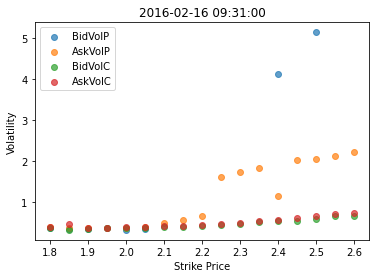

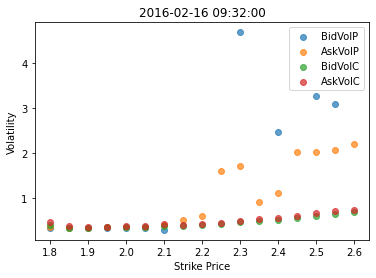

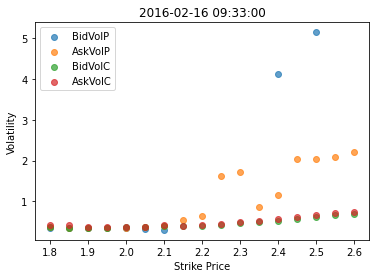

In [13]:
plot_graph()

# 3.3
Aim: Identify an arbitrage opportunities for the data provided


Step 1: Create Data

In [57]:
import math

In [69]:
# read data
marketdata = pd.read_csv('data/marketdata.csv')
instruments = pd.read_csv('data/instruments.csv')

# set time
marketdata['LocalTime'] = pd.to_datetime(marketdata['LocalTime'])

df = pd.merge(marketdata, instruments, on ='Symbol', how ='left') 

df_option = df[df['Type']=='Option']
df_underlying = df[df['Type']=='Equity']

# clean up a bit
df_option.sort_values('LocalTime', inplace=True)
df_underlying.sort_values('LocalTime', inplace=True)
df_option.set_index('LocalTime', inplace=True)
df_underlying.set_index('LocalTime', inplace=True)

# calculate the latest_average_price for the underlying
df_underlying['AvgPrice'] = (df_underlying['Bid1'] + df_underlying['Ask1']) / 2

# create output to hold results
timeperiods = ['2016-02-16 09:31:00', '2016-02-16 09:32:00', '2016-02-16 09:33:00']
default_columns = ['Strike', 'BidP', 'AskP', 'BidC','AskC', 'BidS', 'AskS', 'AvgS']

output2 = {key: {col: [] for col in default_columns} for key in timeperiods}

In [74]:
# iterate to calculate each 

for timeperiod in output.keys():
    
    output2[timeperiod]['Strike'] = instruments['Strike'].unique()[:-1]
    
    # obtain the underlying price
    output2[timeperiod]['AvgS'] = df_underlying[df_underlying.index < timeperiod].iloc[-1,-1]
    output2[timeperiod]['BidS'] = df_underlying[df_underlying.index < timeperiod].iloc[-1]['Bid1']
    output2[timeperiod]['AskS'] = df_underlying[df_underlying.index < timeperiod].iloc[-1]['Ask1']
    
    for strike in output[timeperiod]['Strike']:
        for option_type in ['P', 'C']:
            bs = BlackScholesExtendedModel()
            for price_type in ['Bid', 'Ask']:
                # obtain latest option price for option_type and price_type
                df_temp = df_option[(df_option.index < timeperiod) & (df_option['Strike'] == strike) & (df_option['OptionType'] == option_type)]
                if df_temp.shape[0] == 0:
                    output[timeperiod]['{}Vol{}'.format(price_type, option_type)].append(np.nan)
                    continue
                mkt_option_price = (df_temp.loc[:,'{}1'.format(price_type)]).iloc[-1]
                output2[timeperiod]['{}{}'.format(price_type, option_type)].append(mkt_option_price)

In [120]:
# simply to take a look at an example
output_df = pd.DataFrame(data=output2[timeperiods[0]])
output_df.head()

,Strike,BidP,AskP,BidC,AskC,BidS,AskS,AvgS
0,2.40,0.3912,0.4682,0.0002,0.0004,1.958,1.959,1.9585
1,2.45,0.4803,0.5824,0.0001,0.0004,1.958,1.959,1.9585
2,2.50,0.4828,0.6251,0.0001,0.0004,1.958,1.959,1.9585
3,2.55,0.5330,0.6750,0.0002,0.0004,1.958,1.959,1.9585
4,2.60,0.5827,0.7250,0.0001,0.0003,1.958,1.959,1.9585


Step 2: Identify Arbitrage Opportunities <br>
Below's code identifies whether there is any arbitrage opportunities under the situation where there is no commission.

In [126]:
print("******Arbitrage Strat w/o Commission******")
print()
trading_units = 10000
commission = 0 # per unit


for timeperiod in timeperiods:
    counter = 0
    output_df = pd.DataFrame(data=output2[timeperiod])
    print()
    print('*** {} ***'.format(timeperiod))
    print()
    for _, row in output_df.iterrows():
        # if C + Ke^(-rt) > P + Se^(-q*t)
        # Then execute a conversion:
        # Sell a Call & Borrow @ Strike Price @ risk free rate
        lhs = (row['Strike'] * math.exp(-0.04 * (24-16)/365) * trading_units + row['BidC']*trading_units)
        # Buy a Stock & a Put
        rhs = (row['AskP'] * trading_units + row['AskS']*math.exp(-0.2 * (24-16)/365) * trading_units  + commission*trading_units)
        if lhs > rhs:
            print('*Arbitrage Found @ {} | Conversion @Strike Price ${}'.format(timeperiod, row['Strike']))
            print('**Sell Qt {} Call @ {}: {:.0f}'.format(trading_units, row['BidC'], trading_units*row['BidC']))
            print('**Borrow ${} @ rate 4%: {:.0f}'.format(row['Strike']*trading_units, row['Strike']*trading_units))
            print('**Buy Qt {} Stock @ {} with repo rate: {:.0f}'.format(trading_units, row['AskS'], trading_units*row['AskS']))
            print('**Buy Qt {} Put @ {}: {:.0f}'.format(trading_units, row['AskP'], trading_units*row['AskP']))
            print('**Commision: {}'.format(-commission*trading_units))
            print('***Immediate Payoff: {:.0f}'.format(lhs - rhs))
            print()
            counter += 1
        # if C + Ke^(-rt) < P + Se^(-q*t)
        # Then execute a reverse conversion:
        # Buy a Call & Buy a T-bill @ Risk-free rate
        lhs = (row['Strike'] * math.exp(-0.04 * (24-16)/365)*trading_units + row['AskC']*trading_units + commission*trading_units)
        # Sell a Stock & a Put,
        rhs = (row['BidP']*trading_units + row['BidS']*trading_units*math.exp(-0.2 * (24-16)/365))
        
        if lhs < rhs:
            print('Arbitrage Found @ {} | Reverse Conversion @Strike Price ${}'.format(timeperiod, row['Strike']))
            print('**Buy Qt {} Call @ {}: {:.0f}'.format(trading_units, row['AskC'], -trading_units * row['AskC']))
            print('**Buy ${} T-bills @ rate 4%: {:.0f}'.format(row['Strike']*trading_units, -row['Strike']*trading_units))
            print('**Buy Qt {} Stock @ {} with repo rate: {:.0f}'.format(trading_units, row['AskS'], trading_units*row['AskS']))
            print('**Sell Qt {} Put @ {}: {:.0f}'.format(trading_units, row['BidP'], trading_units* row['BidP']))
            print('**Commision: {}'.format(-commission*trading_units))
            print('***Immediate Payoff: {:.0f}'.format(rhs - lhs))
            print()
            counter += 1
    print()
    print('{} arbitrage opportunities have been found in {}'.format(counter, timeperiod))
    print()
        

******Arbitrage Strat w/o Commission******


*** 2016-02-16 09:31:00 ***


0 arbitrage opportunities have been found in 2016-02-16 09:31:00


*** 2016-02-16 09:32:00 ***

*Arbitrage Found @ 2016-02-16 09:32:00 | Conversion @Strike Price $2.0
**Sell Qt 10000 Call @ 0.0227: 227
**Borrow $20000.0 @ rate 4%: 20000
**Buy Qt 10000 Stock @ 1.9569999999999999 with repo rate: 19570
**Buy Qt 10000 Put @ 0.07200000000000001: 720
**Commision: 0
***Immediate Payoff: 5

*Arbitrage Found @ 2016-02-16 09:32:00 | Conversion @Strike Price $1.8
**Sell Qt 10000 Call @ 0.155: 1550
**Borrow $18000.0 @ rate 4%: 18000
**Buy Qt 10000 Stock @ 1.9569999999999999 with repo rate: 19570
**Buy Qt 10000 Put @ 0.0035: 35
**Commision: 0
***Immediate Payoff: 15


2 arbitrage opportunities have been found in 2016-02-16 09:32:00


*** 2016-02-16 09:33:00 ***

*Arbitrage Found @ 2016-02-16 09:33:00 | Conversion @Strike Price $2.0
**Sell Qt 10000 Call @ 0.0229: 229
**Borrow $20000.0 @ rate 4%: 20000
**Buy Qt 10000 Stock @ 1

Below's code identifies whether there is any arbitrage opportunities under the situation where there is a commission.

In [123]:
print("******Arbitrage Strat w/o Commission******")
print()
trading_units = 10000
commission = 3.3 # per unit


for timeperiod in timeperiods:
    counter = 0
    output_df = pd.DataFrame(data=output2[timeperiod])
    print()
    print('*** {} ***'.format(timeperiod))
    print()
    for _, row in output_df.iterrows():
        # if C + Ke^(-rt) > P + Se^(-q*t)
        # Then execute a conversion:
        # Sell a Call & Borrow @ Strike Price @ risk free rate
        lhs = (row['Strike'] * math.exp(-0.04 * (24-16)/365) * trading_units + row['BidC']*trading_units)
        # Buy a Stock & a Put
        rhs = (row['AskP'] * trading_units + row['AskS']*math.exp(-0.2 * (24-16)/365) * trading_units  + commission*trading_units)
        if lhs > rhs:
            print('*Arbitrage Found @ {} | Conversion @Strike Price ${}'.format(timeperiod, row['Strike']))
            print('**Sell Qt {} Call @ {}: {:.0f}'.format(trading_units, row['BidC'], trading_units*row['BidC']))
            print('**Borrow ${} @ rate 4%: {:.0f}'.format(row['Strike']*trading_units, row['Strike']*trading_units))
            print('**Buy Qt {} Stock @ {} with repo rate: {:.0f}'.format(trading_units, row['AskS'], trading_units*row['AskS']))
            print('**Buy Qt {} Put @ {}: {:.0f}'.format(trading_units, row['AskP'], trading_units*row['AskP']))
            print('**Commision: {}'.format(-commission*trading_units))
            print('***Immediate Payoff: {:.0f}'.format(lhs - rhs))
            print()
            counter += 1
        # if C + Ke^(-rt) < P + Se^(-q*t)
        # Then execute a reverse conversion:
        # Buy a Call & Buy a T-bill @ Risk-free rate
        lhs = (row['Strike'] * math.exp(-0.04 * (24-16)/365)*trading_units + row['AskC']*trading_units + commission*trading_units)
        # Sell a Stock & a Put,
        rhs = (row['BidP']*trading_units + row['BidS']*trading_units*math.exp(-0.2 * (24-16)/365))
        
        if lhs < rhs:
            print('Arbitrage Found @ {} | Reverse Conversion @Strike Price ${}'.format(timeperiod, row['Strike']))
            print('**Buy Qt {} Call @ {}: {:.0f}'.format(trading_units, row['AskC'], -trading_units * row['AskC']))
            print('**Buy ${} T-bills @ rate 4%: {:.0f}'.format(row['Strike']*trading_units, -row['Strike']*trading_units))
            print('**Buy Qt {} Stock @ {} with repo rate: {:.0f}'.format(trading_units, row['AskS'], trading_units*row['AskS']))
            print('**Sell Qt {} Put @ {}: {:.0f}'.format(trading_units, row['BidP'], trading_units* row['BidP']))
            print('**Commision: {}'.format(-commission*trading_units))
            print('***Immediate Payoff: {:.0f}'.format(rhs - lhs))
            print()
            counter += 1
    print()
    print('{} arbitrage opportunities have been found in {}'.format(counter, timeperiod))
    print()
        

******Arbitrage Strat w/o Commission******


*** 2016-02-16 09:31:00 ***


0 arbitrage opportunities have been found in 2016-02-16 09:31:00


*** 2016-02-16 09:32:00 ***


0 arbitrage opportunities have been found in 2016-02-16 09:32:00


*** 2016-02-16 09:33:00 ***


0 arbitrage opportunities have been found in 2016-02-16 09:33:00



Hence the result shows that when there is a commission, 3 arbitrage opportunities were identified. However when commission is taken into account, there are no arbitrage opportunities.